# Presentation Notebook for The **Simulators**

First step to using this package will always be defining the location of the input files and data

In [1]:
from pathlib import Path
import pandas as pd
import networkx as nx

from src.power_system_simulation.graph_processing import GraphProcessor
from src.power_system_simulation import calculation_module as calc
from src.power_system_simulation import validate_power_system_simulation as validate
from src.power_system_simulation import ev_penetration as EV
DATA_PATH = Path.cwd() / "tests" / "data" / "Exception_test_data"

metadata = DATA_PATH / "meta_data.json"
input_network = DATA_PATH / "input_network_data.json"
active_power_profile = DATA_PATH / "active_power_profile.parquet"
reactive_power_profile = DATA_PATH / "reactive_power_profile.parquet"
ev_active_power_profile = DATA_PATH / "ev_active_power_profile.parquet"

ImportError: cannot import name 'ev_penetration' from 'power_system_simulation' (c:\Users\20212771\OneDrive\Uni_storage\Q4\4XWG0\power-system-simulation-simulators\.venv\Lib\site-packages\power_system_simulation\__init__.py)

 validate function is called which checks and validates the data

### **Args:**

**input_network**(str) location of the input data in a string

**metadata**(str) location of the metadata in a string

**ev_active_power_profile**(str) location of the ev_active_power_profile in a string

### **Raises**
- **TimestampsDoNotMatchError** (Timestamps of active and reactive power profiles do not match.)
- **LoadIdsDoNotMatchError** (Load IDs of active and reactive power profiles do not match.)
- **IDNotFoundError** (Vertex ID present in edge_vertex_id_pairs does not exist.)
- **InputLengthDoesNotMatchError** (The amount of vertex pairs is not equal to the amount of edges.)
- **IDNotUniqueError** (vertex and edge ids are not unique.)
- **GraphNotFullyConnectedError** (Graph not fully connected)
- **GraphCycleError** (The graph contains cycles.)
- **TooManyTransformers** (This Input data contains more than one transformer)
- **TooManySources** (This Input data contains more than one source)
- **NotAllFeederIDsareValid** (not all feeders are valid lines)
- **TransformerAndFeedersNotConnected** (Feeders and transformers are not connected to the same graph)
- **TooFewEVs** (there are less EVs profiles than symloads)


In [2]:
validate.validate_power_system_simulation(input_network, metadata,ev_active_power_profile)

NameError: name 'input_network' is not defined

Next the various functions of the package include: 
- making a graph
- visualizing a graph 
- finding a downstream vertice
- finding alternative edges
- Powergrid power calculations 
- finding an optimal tap position
- EV penetration level 
- N-1 calculation

## Making a graph
- A class for processing undirected graphs.
- This class provides functionality to initialize a graph, find downstream vertices of an edge, and identify alternative edges for ensuring graph connectivity.

Attributes:
- graph: A NetworkX graph representing the processed graph.

Args:
- **vertex_ids** (List[int]): List of vertex IDs.
- **edge_ids** (List[int]): List of edge IDs.
- **edge_vertex_id_pairs** (List[Tuple[int, int]]): List of tuples - - representing vertex pairs for each edge.
- **edge_enabled** (List[bool]): List indicating whether each edge is - enabled (True) or disabled (False).
- **source_vertex_id** (int): ID of the source vertex.

Raises:
- **IDNotUniqueError**: If there are duplicate vertex or edge IDs.
- **InputLengthDoesNotMatchError**: If the length of edge_enabled does not match the input lists edge_ids.
- **IDNotFoundError**: If a vertex ID present in edge_vertex_id_pairs does not exist in vertex_ids.
- **GraphNotFullyConnectedError**: If the graph is not fully connected.
- **GraphCycleError**: If the graph contains cycles.

To demonstrate the functionality of the class, the grid can be created as follows:

In [3]:
vertex_ids = [0, 2, 4, 6, 10]
edge_ids = [1, 3, 5, 7, 8, 9]
edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
edge_enabled = [True, True, True, False, False, True]
source_vertex_id = 10

grid = GraphProcessor(vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id)

## Visualizing a graph
Now, the graph can be visualized as follows:

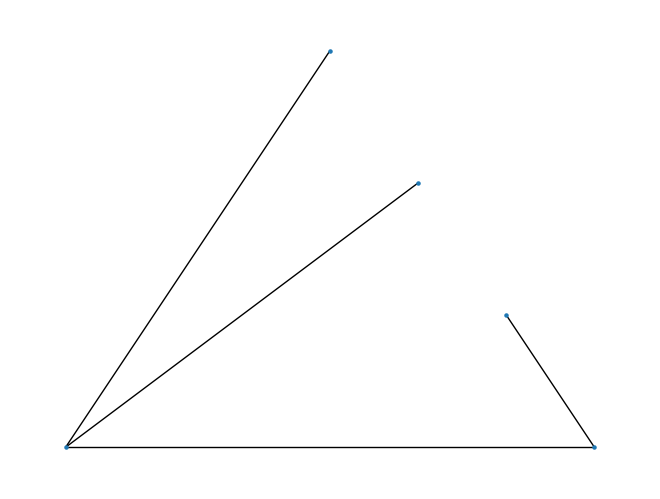

In [4]:
pos = nx.spring_layout(grid.graph)
nx.draw_planar(grid.graph, node_size=5)

## Finding a downstream vertice
 Args:
- starting_edge_id (int): ID of the edge to find downstream vertices for.

Returns:
- List[int]: List of vertex IDs downstream from the specified edge.

### Working Principle:
- Verify that the edge ID exists
- Check if the edge is already disabled, which would be 
- Get the vertices of the edge
- Simulate the edge being disabled by temporarily removing it
- Find all connected components after the removal
- Restore the edge to maintain original graph state
- Determine which component contains the source vertex
- Return the nodes in the component that does not contain the source vertex


In [5]:
downstream_vertices = grid.find_downstream_vertices(1)
downstream_vertices

[0, 4, 6]

# *Finding alternative edges*

## *Purpose*

Given the ID of an edge, the function will return a list of edges that if connected, will result in a graph that maintains its integrity (i.e. is acyclic)

### *Arguments:*
- disabled_edge_id (int): The ID of the edge to be disabled.

### *Returns:*
- List[int]: A list of alternative edge IDs that can replace disabled_edge_id

### *Working principle*:
-STEP 1.  a list of <ins>originally</ins> disabled edges is created

-STEP 2.  <ins>errors</ins> are checked ; <ins>empty output list</ins> is initialised for later usage

-STEP 3.  a <ins>new list of disabled edges</ins> is made by updating the old list with <ins>disabled_edge_id</ins> considered

-STEP 4.  a list of edges is created where every edge id is paired with the corresponding vertex (node) pairs and (dis)/(en)abled status (e.g. <ins>[ ID, (adj node 1 , adj node 2), True ]</ins> )

-STEP 5.  the edge list is updated (i.e. disabled_edge_id added as disabled)

-STEP 6.  while loop iteration through <ins>originally disabled edges</ins>. For each iteration, the <ins>disabled edge is "temporarily" enabled</ins> and a new graph is made. This new graph is then <ins>checked for cyclicity and completeness</ins>. If satisfactory, the ORIGINALLY disabled index is added to the output list alt_list[]

-STEP 7.  after iterations end, the <ins>output list is printed</ins>

The function was tested on a graph of 10 nodes. Below, the function is called with an edge ID = 3. the function returns a list containing two IDs [7, 8] and the resulting graphs (acyclical in this case) are plotted.

In [7]:
alternative_edges = grid.find_alternative_edges(3)
alternative_edges

[7, 8]

# Large Powergrid
now we have seen how a small graph can be created, a large powergrid is loaded for the following sections.

In [13]:
DATA_PATH = Path('C:/Users/20212771/Downloads/big_network/input')
metadata = DATA_PATH / "meta_data.json"
input_network = DATA_PATH / "input_network_data.json"
active_power_profile = DATA_PATH / "active_power_profile.parquet"
reactive_power_profile = DATA_PATH / "reactive_power_profile.parquet"
ev_active_power_profile = DATA_PATH / "ev_active_power_profile.parquet"

## Validation

The input is once more validates to ensure that it is compatible with the data

In [10]:
validate.validate_power_system_simulation(input_network, metadata,ev_active_power_profile)

## Powergrid power calculations:
- Analyze power flow on the given power grid network using provided active and reactive power profile data.

function: 
- calculate_power_grid()

Args:
- **input_network_data** (Dict): Input network data in JSON format.
- **active_power_profile_path** (str): Path to the parquet file containing active power profile data.
- **reactive_power_profile_path** (str): Path to the parquet file containing reactive power profile data.

Returns:
- Dict: Aggregated power flow results containing voltage statistics and line loading information.

### Working Principle:
- Load input network data
- Validate input data
- Load active and reactive power profiles
- Check if timestamps and load IDs match
- Create PGM batch update dataset
- Validate batch data
- Run power flow calculations
- Aggregating voltage results
- Aggregating line loading results
- Create DataFrame for voltage results
- Create DataFrame for line results
- Return aggregated results

In [8]:
from src.power_system_simulation.calculation_module import (
    calculate_power_grid,
)

voltage_results, line_results = calculate_power_grid(
        input_network, active_power_profile, reactive_power_profile
)
voltage_results

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.074658,1,1.049898,0
2025-01-01 00:15:00,1.074532,1,1.049891,0
2025-01-01 00:30:00,1.074927,1,1.049916,0
2025-01-01 00:45:00,1.074601,1,1.049894,0
2025-01-01 01:00:00,1.074482,1,1.049885,0
...,...,...,...,...
2025-12-31 22:45:00,1.070302,1,1.049715,0
2025-12-31 23:00:00,1.070859,1,1.049746,0
2025-12-31 23:15:00,1.070879,1,1.049734,0


In [9]:
print("Line Results:")
line_results

Line Results:


,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,214.476076,5.824780e-02,2025-11-07 09:45:00,4.447163e-03,2025-10-08 12:45:00
1205,0.736725,5.680893e-03,2025-04-07 10:30:00,4.082249e-07,2025-03-04 17:15:00
1206,219.597895,5.442560e-02,2025-11-05 23:15:00,3.731235e-03,2025-10-08 12:45:00
1207,0.898303,4.752569e-03,2025-05-29 02:30:00,4.118517e-07,2025-12-29 15:30:00
1208,202.147152,5.648105e-02,2025-11-07 09:45:00,3.791173e-03,2025-10-08 12:45:00
...,...,...,...,...,...
2006,0.032063,2.444916e-07,2025-10-02 19:45:00,2.399379e-07,2025-11-05 07:30:00
2007,0.031663,2.445316e-07,2025-10-08 17:45:00,2.401123e-07,2025-11-04 22:30:00
2008,0.037419,2.444854e-07,2025-10-02 20:15:00,2.395951e-07,2025-11-07 15:00:00


## Finding an optimal tap position

Find the optimal tap position of the transformer to ensure either the minimal total energy loss of all the lines and the whole time period or the minimal (averaged across all nodes) deviation of max p.u. node voltages with respect to 1 p.u. 

## Input arguments
- input_network_data               json file of the network 
- active_power_profile_path        parquet file of active power
- reactive_power_profile_path      parquet file of reactive power
- optimize_by                      select which condition it should be optimized by: 0 (for minimal losses) or 1 (for minimal deviation)

## Working principle
1. Get the min and max tap position
2. Loop through all tap positions
3. For every tap position determine the total amount of losses and deviation of max voltage compared to 1 p.u.
4. Compare to previous value to check if its lower (or save it if its the first iteration of the loop) and save the tap position

In [ ]:
import power_system_simulation.optimal_tap_position as otp

tap_position_total_losses = otp.optimal_tap_position(
        input_network, active_power_profile, reactive_power_profile, 0
    )

tap_position_average_dev = otp.optimal_tap_position(
        input_network, active_power_profile, reactive_power_profile, 1
    )

print(tap_position_total_losses, tap_position_average_dev)

# EV Penetration
### Args:
- input_network_data (str): Path to the input network data file.
- meta_data_str (str): Path to the metadata file.
- active_power_profile_path (str): Path to the active power profile file.
- ev_active_power_profile (str): Path to the EV active power profile file.
- percentage (float): Percentage of EV penetration.
- seed (int): Seed for random number generation.
### Returns:
A tuple containing two pandas DataFrames:
- voltage_df: DataFrame with voltage results.
- line_df: DataFrame with line loading results.

## Working principle

### Step 1
- a mapping of sym_load IDs to feeders is performed. A dictionary feeder_to_loads is initialized to store load IDs for each feeder. For each feeder, downstream vertices are found using G.find_downstream_vertices. Matching sym_load IDs that are found within these vertices are identified, and a random sample of these IDs, limited by EV_feeder, is selected and added to feeder_to_loads and selected_ids.


### Step 2
- a filtered profiles are generated by creating filtered_profile, which selects rows from active_power_profile using selected_ids.


### Step 3
- a randomly selected EV power profiles are created by choosing an equal number of columns from ev_power_profile to match the number of selected_ids, creating selected_ev_profile.


### Step 4
- profiles are aligned and summed by setting the index of selected_ev_profile to match filtered_profile and aligning columns accordingly. Element-wise addition of filtered_profile and selected_ev_profile is performed to create summed_profile.


### Step 5
- an update_sym_load array is initialized to store updated load data. IDs and specified powers are updated with summed_profile data, and an update_data dictionary is created containing update_sym_load.


### Step 6
- the assert_valid_batch_data function is called to validate the update. A copy of the model is created and updated with update_data, and power flow calculations are performed using calculate_power_flow.


### Step 7
- voltage and line loading results are extracted and aggregated into DataFrames. Maximum and minimum voltages, and loadings are identified along with corresponding nodes and timestamps. Total energy losses are calculated for each line.

### Step 8
- the function returns two DataFrames: voltage_df and line_df.

In [14]:
P=50
Seed=42

a, b = EV.ev_penetration(input_network, metadata, active_power_profile, ev_active_power_profile, P, Seed)
a

C:\Users\20212771\Downloads\big_network\input\input_network_data.json


,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.075633,1,1.049935,0
2025-01-01 00:15:00,1.075543,1,1.049931,0
2025-01-01 00:30:00,1.075670,1,1.049936,0
2025-01-01 00:45:00,1.075595,1,1.049933,0
2025-01-01 01:00:00,1.075356,1,1.049924,0
...,...,...,...,...
2025-12-31 22:45:00,1.073141,1,1.049837,0
2025-12-31 23:00:00,1.073125,1,1.049837,0
2025-12-31 23:15:00,1.073422,1,1.049849,0


In [15]:
b

,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,69.991301,5.675621e-02,2025-05-29 18:15:00,7.993340e-04,2025-11-28 05:00:00
1205,0.031654,4.215844e-07,2025-10-07 19:00:00,4.189281e-07,2025-12-26 21:45:00
1206,74.560012,5.327842e-02,2025-05-29 18:15:00,7.503395e-04,2025-11-28 05:00:00
1207,1.565130,1.543689e-02,2025-04-13 09:45:00,4.212385e-07,2025-05-04 09:00:00
1208,66.224681,5.480160e-02,2025-06-08 22:45:00,5.493672e-04,2025-11-28 05:00:00
...,...,...,...,...,...
2006,0.032278,2.448045e-07,2025-01-18 05:45:00,2.401807e-07,2025-12-26 21:00:00
2007,0.031860,2.447555e-07,2025-10-07 19:00:00,2.398692e-07,2025-05-29 22:30:00
2008,0.037658,2.447717e-07,2025-08-08 13:00:00,2.388985e-07,2025-04-21 22:30:00


## N-1 calculation
### *Purpose*
The user selects a line ID for disabling. The function will first compute a list of alternative edges that, when turned on, will ensure that the network remains fully connected and acyclical. Based on this list, the power flow calculations are done for each scenario (i.e. each alternative line/edge).

#### *Arguments*
- ID of edge that will be disabled
- Metadata path
- Input data path
- Active power profile path
- Reactive power profile path

#### *Returns*
- List of alternative edges
- Prints Table with Alternative ID, Maximum line loading + corresponding line ID + timestamp

#### *Working principle*
- *Step1.* Open Input Data from paths (function/method arguments)

- *Step2.* Extract and Prepare Data for Graph Processing (i.e. isolate vertices, edges, IDs, status-enebled or not)

- *Step3.* Data is modified such that the transformer is considered as an edge (i.e. for connecting the source with the LV busbar) such that the find_alternative_edges method is called with a fully connected graph

- *Step4.* Initialize an object of type GraphProcessing (i.e. the class that initializes the graph)

- *Step5.* Error Handling (provided ID not valid and/or already disconnected)

- *Step6.* Find Alternative Edges (using the method made in Assignment 1)

- *Step7.* Iterate through list of alternative edges
    - *a.* Original input_data is updated in a copy by enabling desired edge
    - *b.* Perform time-series power flow calculation
    - *c.* Add desired output data to table as a row
    - *d.* Remove updated data from memory

- *Step8.* Print output table

Execution time for Batch Calculation using the linear method is 7.052158 s
+----------------+---------------------+--------+---------------------+
| Alternative ID |     Max Loading     | ID_max |    Timestamp_max    |
+----------------+---------------------+--------+---------------------+
|      2009      | 0.08212363281714392 |  1906  | 2024-11-04 06:45:00 |
+----------------+---------------------+--------+---------------------+
Execution time for Batch Calculation using the linear method is 7.273904 s
+----------------+---------------------+--------+---------------------+
| Alternative ID |     Max Loading     | ID_max |    Timestamp_max    |
+----------------+---------------------+--------+---------------------+
|      2009      | 0.08212363281714392 |  1906  | 2024-11-04 06:45:00 |
|      2010      | 0.08057895119685762 |  1906  | 2024-11-04 18:15:00 |
+----------------+---------------------+--------+---------------------+


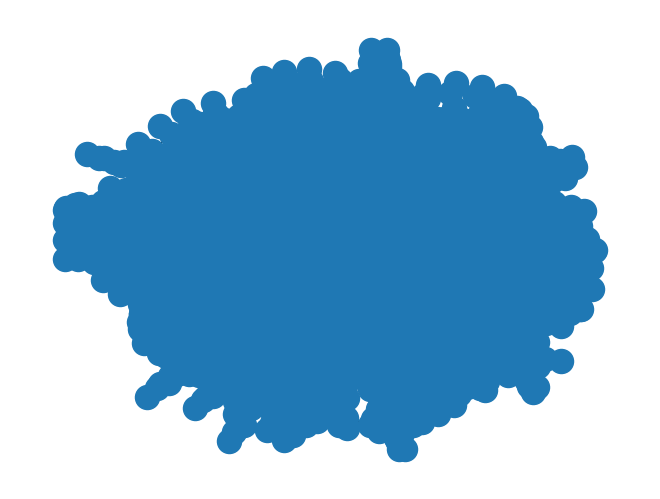

In [16]:
import src.power_system_simulation.Nm_calculation as nm_file
call = nm_file.Nm_function(
        1894, input_network, metadata, active_power_profile, reactive_power_profile
    )

In [ ]:
pos = nx.spring_layout(grid.graph)
nx.draw_planar(grid.graph, node_size=5)